Link for the dataset: 
https://cvml.ista.ac.at/AwA2/        
13GB file : https://cvml.ista.ac.at/AwA2/AwA2-data.zip

In [19]:
import sys
import os
import csv

import numpy as np 
import pandas as pd 
import math
import matplotlib.pyplot as plt 
import seaborn as sns

import torch 
from torch.utils.data import Dataset, DataLoader
import torchvision 
from torchvision.io import read_image
import torchvision.datasets as datasets
import torchvision.transforms as transforms

np.random.seed(0)

In [2]:
# Constant. Should be the path to the folder named JPEGImages, containing the 33K images in its subfolders.
DATA_FOLDER_PATH = "YOURPATH\\\Animals_with_Attributes2\\"
JPEGIMAGES_FOLDER_PATH = "YOURPATH\\JPEGImages\\"
labels_dirs = os.listdir(JPEGIMAGES_FOLDER_PATH)


In [6]:
def find_num_images_per_label(img_dir = JPEGIMAGES_FOLDER_PATH) -> tuple[dict,dict]: 
    """ 
    USEFUL FOR SAMPLING.
    Return a dict with keys as the 50 labels, and values being the number of images in each subdirectory corresponding to label
    and a second dict with the relative numbers (proportion) for every label compared to the total number of images (useful for sampling)"""
    labels_dirs = os.listdir(img_dir)
    num_images_per_label = dict.fromkeys(labels_dirs)
    proportions_images_per_label = dict.fromkeys(labels_dirs)
    total_num_images = 0

    # Update absolute number of images per label
    for i, label in enumerate(labels_dirs) : 
        specific_label_path = os.path.join(img_dir, labels_dirs[i])
        num_images_label = len(os.listdir(specific_label_path))
        total_num_images += num_images_label
        num_images_per_label[label] = num_images_label

    # Update relative number of images per label (proportion)
    for i, label in enumerate(labels_dirs) : 
        num_images_label = num_images_per_label[label]
        proportion_label = round(num_images_label / total_num_images, 4)
        proportions_images_per_label[label] = proportion_label

    return num_images_per_label, proportions_images_per_label

num_images_per_label, proportions_images_per_label = find_num_images_per_label()
print(num_images_per_label)
print(proportions_images_per_label)

{'antelope': 1046, 'bat': 383, 'beaver': 193, 'blue+whale': 174, 'bobcat': 630, 'buffalo': 895, 'chihuahua': 567, 'chimpanzee': 728, 'collie': 1028, 'cow': 1338, 'dalmatian': 549, 'deer': 1344, 'dolphin': 946, 'elephant': 1038, 'fox': 664, 'german+shepherd': 1033, 'giant+panda': 874, 'giraffe': 1202, 'gorilla': 872, 'grizzly+bear': 852, 'hamster': 779, 'hippopotamus': 684, 'horse': 1645, 'humpback+whale': 709, 'killer+whale': 291, 'leopard': 720, 'lion': 1019, 'mole': 100, 'moose': 704, 'mouse': 185, 'otter': 758, 'ox': 728, 'persian+cat': 747, 'pig': 713, 'polar+bear': 868, 'rabbit': 1088, 'raccoon': 512, 'rat': 310, 'rhinoceros': 696, 'seal': 988, 'sheep': 1420, 'siamese+cat': 500, 'skunk': 188, 'spider+monkey': 291, 'squirrel': 1200, 'tiger': 877, 'walrus': 215, 'weasel': 272, 'wolf': 589, 'zebra': 1170}
{'antelope': 0.028, 'bat': 0.0103, 'beaver': 0.0052, 'blue+whale': 0.0047, 'bobcat': 0.0169, 'buffalo': 0.024, 'chihuahua': 0.0152, 'chimpanzee': 0.0195, 'collie': 0.0275, 'cow': 0.

100
mole


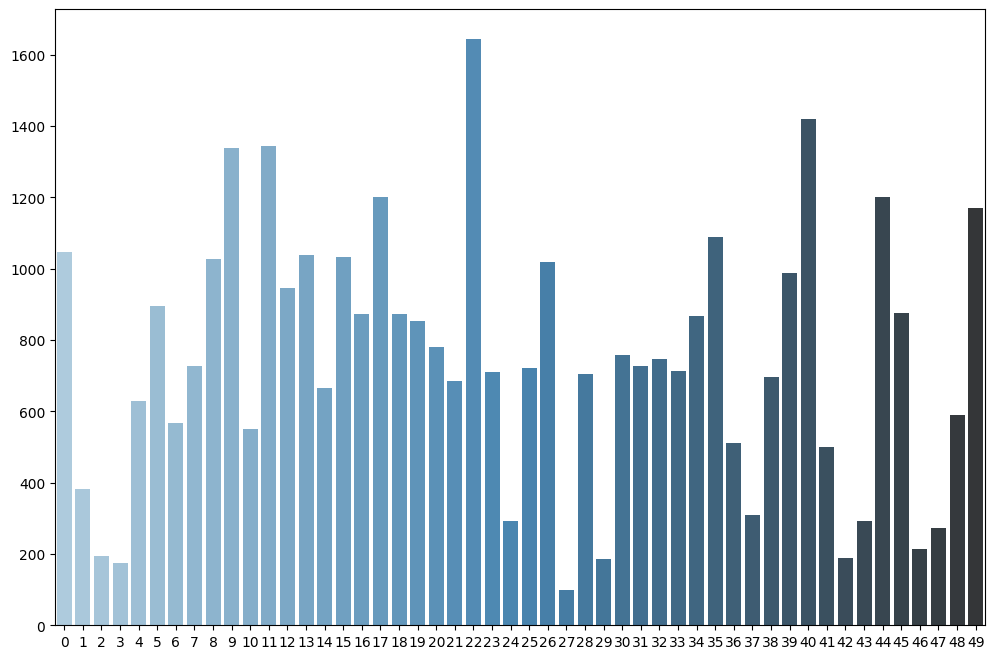

In [35]:
names = list(num_images_per_label.keys())
vals = list(num_images_per_label.values())

fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(y=vals, x=list(range(50)), palette=("Blues_d"))

print(np.min(vals))
print(names[np.argmin(vals)])

In [ ]:
ANNOTATIONS_FILENAME = 'annotations.csv'

def create_annotations_csv_file(annotations_filename = ANNOTATIONS_FILENAME, img_dir = JPEGIMAGES_FOLDER_PATH) : 
    """ 
    Create a csv annotations_file, annotations.csv, with two columns, in the format : 
                        path/to/image, label
    
    The annotation csv is necessary for DataLoader.
    """

    labels_dirs:list = os.listdir(img_dir)
   
    if os.path.exists(annotations_filename):
        os.remove(annotations_filename)
        print(f'Deleted existent {ANNOTATIONS_FILENAME} file.\n ---------------------------')
    
    with open(annotations_filename, 'w', newline='') as file :
        writer = csv.writer(file, dialect='excel', delimiter=',')

        for i, label in enumerate(labels_dirs) : 

            specific_label_path = os.path.join(img_dir, label)
            images_names = os.listdir(specific_label_path)

            for j, image_name in enumerate(images_names):
                full_path_to_img= os.path.join(specific_label_path, image_name)
                full_path_to_img= os.path.join(label, image_name)

                row = [full_path_to_img, label]
                writer.writerow(row)

    print(f'Sucessfully created {ANNOTATIONS_FILENAME} file.')

create_annotations_csv_file()

Deleted existent annotations.csv file.
 ---------------------------
Sucessfully created annotations.csv file.


In [ ]:
labels_dict = {}
with open(DATA_FOLDER_PATH+"classes.txt") as f:
    for line in f:
        (key,val) = line.split()
        labels_dict[val] = int(key)-1
print(labels_dict)

{'antelope': 0, 'grizzly+bear': 1, 'killer+whale': 2, 'beaver': 3, 'dalmatian': 4, 'persian+cat': 5, 'horse': 6, 'german+shepherd': 7, 'blue+whale': 8, 'siamese+cat': 9, 'skunk': 10, 'mole': 11, 'tiger': 12, 'hippopotamus': 13, 'leopard': 14, 'moose': 15, 'spider+monkey': 16, 'humpback+whale': 17, 'elephant': 18, 'gorilla': 19, 'ox': 20, 'fox': 21, 'sheep': 22, 'seal': 23, 'chimpanzee': 24, 'hamster': 25, 'squirrel': 26, 'rhinoceros': 27, 'rabbit': 28, 'bat': 29, 'giraffe': 30, 'wolf': 31, 'chihuahua': 32, 'rat': 33, 'weasel': 34, 'otter': 35, 'buffalo': 36, 'zebra': 37, 'giant+panda': 38, 'deer': 39, 'bobcat': 40, 'pig': 41, 'lion': 42, 'mouse': 43, 'polar+bear': 44, 'collie': 45, 'walrus': 46, 'raccoon': 47, 'cow': 48, 'dolphin': 49}


In [ ]:
from torchvision.io import read_image, ImageReadMode

class AWA2Dataset(Dataset): # Dataset class to serve as input for the DataLoader.
    """ 
    Dataset class to serve as input for the DataLoader.
    Implements all the required methods and more. 
    """

    def __init__(self, annotations_file=ANNOTATIONS_FILENAME, img_dir=JPEGIMAGES_FOLDER_PATH, 
                transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

        numbers_infos_dicts: tuple[dict,dict] = find_num_images_per_label(img_dir=JPEGIMAGES_FOLDER_PATH)
        self.num_images_per_label = numbers_infos_dicts[0]
        self.proportions_images_per_label = numbers_infos_dicts[1]

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        # img_path = self.img_labels.iloc[idx, 0]
        key = self.img_labels.iloc[idx, 1]

        # Mapping the labels from string to tensor
        label = labels_dict[key]

        image = read_image(path = img_path, mode = ImageReadMode.RGB)

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


class Subset_(AWA2Dataset) : 
    def __init__(self, dataset, indices, transform=None):
        super().__init__()
        self.dataset = dataset
        self.indices = indices
        self.transform = transform
    
    def __len__(self):
        return len(self.indices)

    def __getitem__(self, index):
        original_index_in_AWA2Dataset = self.indices[index]
        image, label = self.dataset[original_index_in_AWA2Dataset]
        if self.transform:
            image = self.transform(image)
        return image, label
    

In [10]:
# With Data augmentation to remedy overfitting 
transforms_pipeline_train = transforms.Compose([
                    ## Input size
                    transforms.ToPILImage(),
                    transforms.Resize((256,256)),
                    
                    ## Data augmentation 
                    transforms.RandomRotation(15),
                    transforms.RandomHorizontalFlip(p=0.4),
                    transforms.ColorJitter(brightness=0.2,
                                            contrast=0.2,
                                            saturation=0.2,
                                            hue=0.1),
                    transforms.RandomCrop((224,224)),  
                    ## Normalize
                    transforms.ToTensor(), 
                    transforms.Normalize(mean = [0.4643, 0.4640, 0.3985] , std=[0.2521, 0.2425, 0.2538]) # real mean and std of AwA2
                ])


transforms_pipeline_test = transforms.Compose([
                    ## Input size
                    transforms.ToPILImage(),
                    transforms.Resize((256,256)),
                    transforms.CenterCrop((224,224)),   
                    ## Normalize
                    transforms.ToTensor(), # Already a tensor as implemented in Dataset class with the 
                    transforms.Normalize(mean = [0.4643, 0.4640, 0.3985] , std=[0.2521, 0.2425, 0.2538]) # real mean and std of AwA2
                ])



# Initialize dataset and train/valid/test split 
from sklearn.model_selection import train_test_split

dataset = AWA2Dataset()
n_images = len(dataset)

# Split all indices into training/testing sets
train_indices, test_indices = train_test_split(range(n_images), test_size=0.2, random_state=1)
# Split training indices into training/validation sets.
train_indices, valid_indices = train_test_split(train_indices, test_size=0.2, random_state=1)


# Initialize the 3 DataSet objects (as Subset_) and apply the relevant Transforms to each subset (train/test/valid)
train_data = Subset_(dataset, train_indices, transform = transforms_pipeline_train)
valid_data = Subset_(dataset, valid_indices, transform = transforms_pipeline_test)
test_data  = Subset_(dataset, test_indices, transform = transforms_pipeline_test) 

# Initalize DataLoaders
batch_size = 32
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True, num_workers=6, pin_memory=True)
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=False, num_workers=6, pin_memory=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=False, num_workers=6, pin_memory=True)

# Verifying the implementation

In [25]:
# Experiment with DataLoader. Everything works good
dataloader = DataLoader(dataset = dataset, batch_size=4, shuffle=True)
dataiter = iter(dataloader)
data = next(dataiter)

images, labels = data 
print(labels, images)

('horse', 'giraffe', 'hippopotamus', 'tiger') tensor([[[[226, 227, 226,  ..., 225, 224, 224],
          [227, 224, 228,  ..., 226, 223, 223],
          [226, 229, 225,  ..., 225, 223, 221],
          ...,
          [170, 137, 167,  ..., 171, 169, 187],
          [220, 227, 220,  ..., 160, 229, 228],
          [208, 208, 217,  ..., 180, 163, 188]],

         [[232, 232, 231,  ..., 225, 225, 225],
          [231, 228, 232,  ..., 225, 227, 227],
          [232, 230, 229,  ..., 224, 226, 224],
          ...,
          [165, 131, 166,  ..., 169, 168, 184],
          [219, 227, 217,  ..., 156, 229, 220],
          [207, 207, 218,  ..., 176, 158, 185]],

         [[233, 232, 232,  ..., 229, 228, 229],
          [233, 229, 233,  ..., 230, 230, 230],
          [233, 234, 230,  ..., 230, 229, 229],
          ...,
          [165, 141, 172,  ..., 164, 160, 178],
          [214, 221, 211,  ..., 145, 221, 217],
          [202, 204, 213,  ..., 173, 153, 179]]],


        [[[111, 115, 102,  ...,  70, 

In [31]:
# Training loop example
num_epochs = 2 
batch_size = 4
total_samples = len(dataset)
n_iterations = math.ceil(total_samples/batch_size)
print(total_samples, n_iterations)

dataloader = DataLoader(dataset = dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs) : 
    # loop over trainloader 
    for i, (inputs, labels) in enumerate(dataloader) : 
        
        # Do forward and backward pass, update the weights 
        if(i+1) % 5 == 0 :
            print(f'epoch {epoch+1} / {num_epochs}, step, {i+1}/{n_iterations}, inputs {inputs.shape}')

        if i==20 : 
            print('Completed')
            break

37321 9331
epoch 1 / 2, step, 5/9331, inputs torch.Size([4, 3, 224, 224])
epoch 1 / 2, step, 10/9331, inputs torch.Size([4, 3, 224, 224])
epoch 1 / 2, step, 15/9331, inputs torch.Size([4, 3, 224, 224])
epoch 1 / 2, step, 20/9331, inputs torch.Size([4, 3, 224, 224])
Completed
epoch 2 / 2, step, 5/9331, inputs torch.Size([4, 3, 224, 224])
epoch 2 / 2, step, 10/9331, inputs torch.Size([4, 3, 224, 224])
epoch 2 / 2, step, 15/9331, inputs torch.Size([4, 3, 224, 224])
epoch 2 / 2, step, 20/9331, inputs torch.Size([4, 3, 224, 224])
Completed
